# Algebra Linear Algorítmica - Trabalho Final
##  Alunos
- [Diogo Lima](http://www.github.com/dbclima)
- [Antônio Pedro Corrêa](https://github.com/AntonioPedro04)

## Descrição
Neste projeto desenvolveremos um software que recebe alimentos e o objetivo  alimentar de um individuo e retorna a dieta ideal do mesmo.

### Dados de entrada:
- Peso [kg]
- Idade [ano]
- Gênero [M/F]
- Lista de preferencia alimentar

In [112]:
PESO = 78.0
IDADE = 20
GENERO = "M"

LISTA_ALIMENTOS = [3, 36, 173, 2, 90, 123, 174]

7-element Vector{Int64}:
   3
  36
 173
   2
  90
 123
 174

## Bibliotecas Utilizadas

In [113]:
using LinearAlgebra
using CSV
using DataFrames
using JuMP
using Ipopt
using Plots
using Plots.PlotMeasures
using Printf

### Objetivos alimentares
A quantidade ideal de cada nutriente ingerido por dia:
- **Calorias**:
    - Homens: 2400 [kcal]/dia
    - Mulheres: 2000 [kcal]/dia
    - fonte: https://oglobo.globo.com/saude/noticia/2023/01/quantas-calorias-devo-consumir-por-dia.ghtml

- **Proteína**: 
    - Sem exercício: 1.0 [g/kg]/dia
    - Com exercício: 2.0 [g/kg]/dia
    - Consideraremos 1.5 [g/kg]/dia
    - fonte: https://www.metropoles.com/saude/como-calcular-quantidade-proteina-por-dia

- **Lipídeos (Gordura)**
    - 30% da Caloria diária (ou menos)
    - 1g tem cerca de 9 kcal
    - fonte caloria diária: https://www.who.int/news/item/17-07-2023-who-updates-guidelines-on-fats-and-carbohydrates
    - fonte conversão g -> kcal: https://brasilescola.uol.com.br/curiosidades/contando-calorias.htm#:~:text=Um%20grama%20de%20carboidrato%20oferece,fornece%20cerca%20de%209%20kcal.

- **Colesterol**
    - 10% da caloria diária (ou menos)
    - 22g tem cerca de 200 kcal (9 kcal/g)
    - fonte: https://www.healthline.com/health/high-cholesterol/rda

- **Carboidrato**
    - 4 a 6 [g/kg]/dia
    - Consideraremos 5 [g/kg]/dia
    - fonte: https://www.terra.com.br/vida-e-estilo/quantas-gramas-diarias-de-carboidrato-sao-necessarias-para-hipertrofia-entenda,f5f7ce9ed991948b24cbd30bc1e8f9c6njbq608z.html#:~:text=%22Um%20consumo%20m%C3%A9dio%20de%20carboidratos,g%20de%20carboidratos%20por%20dia.

- **Fibra Alimentar**
    - 2-5 anos: 15 g/dia
    - 6-9 anos: 21 g/dia
    - 10+ anos: 25 g/dia
    - fonte: https://www.who.int/news/item/17-07-2023-who-updates-guidelines-on-fats-and-carbohydrates

- **Cálcio**
    - < 1 ano: 260 mg/dia
    - 1-3 anos: 700 mg/dia
    - 4-8 anos: 1000 mg/dia
    - 9-18 anos: 1300 mg/dia
    - 18-70 anos: 1000 mg/dia
    - 70+ anos: 1200 mg/dia
    - fonte: https://www.unimed.coop.br/viver-bem/alimentacao/qual-a-quantidade-de-calcio-que-o-corpo-precisa-e-como-obte-la

- **Magnésio**
    - < 1 ano: 30 mg/dia
    - 1-3 anos: 75 mg/dia
    - 4-8 anos: 80 mg/dia
    - 9-13 anos: 240 mg/dia
    - 14-18 anos: 
        - homem: 410 mg/dia
        - mulher: 360 mg/dia
    - 19-30 anos: 
        - homem: 400 mg/dia
        - mulher: 310 mg/dia
    - 31+ anos: 
        - homem: 420 mg/dia
        - mulher: 320 mg/dia
    - fonte: https://www.healthline.com/nutrition/magnesium-dosage#supplements


In [114]:
function get_dosagens_diarias(idade, peso, genero)
    """Consideraremos a idade em anos, peso em Kg e genero "M" ou "F" """
    vetor_ideal = zeros(8)
    
    # Defendendo Entradas
    if (genero != "M" && genero != "F") || (idade < 0) || (peso < 0)
        return false, vetor_ideal
    end

    # Calorias
    if genero == "M"
        vetor_ideal[1] = 2400
    else
        vetor_ideal[1] = 2000
    end

    # Proteinas
    vetor_ideal[2] = peso * 1.5

    # Lipídeos
    vetor_ideal[3] = (vetor_ideal[1] * 0.3) / 9

    # Colesterol
    vetor_ideal[4] = (vetor_ideal[1] * 0.1) / 9

    # Carboidratos
    vetor_ideal[5] = peso * 5

    # Fibra Alimentar
    if (idade < 2)
        vetor_ideal[6] = 0
    
    elseif (idade < 5)
        vetor_ideal[6] = 15
        
    elseif (idade < 10)
        vetor_ideal[6] = 21
        
    else
        vetor_ideal[6] = 25
    end

    # Calcio
    if (idade < 1)
        vetor_ideal[7] = 260
    
    elseif (idade < 3)
        vetor_ideal[7] = 300

    elseif (idade < 8)
        vetor_ideal[7] = 1000

    elseif (idade < 18)
        vetor_ideal[7] = 1300

    elseif (idade < 70)
        vetor_ideal[7] = 1000

    else
        vetor_ideal[7] = 1200
    end
    
    # Magnésio
    if (idade < 1)
        vetor_ideal[8] = 30

    elseif (idade < 3)
        vetor_ideal[8] = 75

    elseif (idade < 8)
        vetor_ideal[8] = 80

    elseif (idade < 13)
        vetor_ideal[8] = 240

    elseif (idade < 18)
        if (genero == "M")
            vetor_ideal[8] = 410
        else
            vetor_ideal[8] = 360
        end
        
    elseif (idade < 30)
        if (genero == "M")
            vetor_ideal[8] = 400
        else
            vetor_ideal[8] = 310
        end

    else
        if (genero == "M")
            vetor_ideal[8] = 420
        else
            vetor_ideal[8] = 320
        end
    end

    return true, vetor_ideal
end

validade, dosagem_diaria = get_dosagens_diarias(IDADE, PESO, GENERO)
if !validade
    print("Parametro invalido")
end

print(dosagem_diaria)

[2400.0, 117.0, 80.0, 26.666666666666668, 390.0, 25.0, 1000.0, 400.0]

## Dados Utilizados

### Base de alimentos
Os dados refletem as quantidades de nutriente para mais de 300 alimentos.

Fonte de dados: https://www.kaggle.com/datasets/ispangler/composio-nutricional-de-alimentos-taco?select=taco-db-nutrientes.csv

In [115]:
df = CSV.read("tabela_alimentos.csv", DataFrame)
display(df)

Row,Nome,Energia (kcal),Proteína (g),Lipídeos (g),Colesterol (mg),Carboidrato (g),Fibra Alimentar (g),Cálcio (mg),Magnésio (mg)
,String,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Int64
1,Arroz integral cozido,124.0,2.6,1.0,0,25.8,2.7,5.0,59
2,Arroz cozido,128.0,2.5,0.2,0,28.1,1.6,4.0,2
3,Biscoito doce maisena,443.0,8.1,12.0,0,75.2,2.1,54.0,37
4,Biscoito doce recheado com chocolate,472.0,6.4,19.6,0,70.5,3.0,27.0,48
5,Biscoito doce recheado com morango,471.0,5.7,19.6,0,71.0,1.5,36.0,27
6,Biscoito doce wafer recheado de chocolate,502.0,5.6,24.7,0,67.5,1.8,23.0,48
7,Biscoito doce wafer recheado de morango,513.0,4.5,26.4,1,67.4,0.8,14.0,19
8,Biscoito salgado cream cracker,432.0,10.1,14.4,0,68.7,2.5,20.0,40
9,Bolo mistura para,419.0,6.2,6.1,0,84.7,1.7,59.0,28


### Tratando dados
Convertemos as colunas para o tipo correto de dados

In [116]:
for nome in names(df)[3:ncol(df)]
    print(nome, ", ")
    convert(Vector{Float64}, df[!, nome])
end

display(DataFrames.first(df, 5))

Proteína (g), Lipídeos (g), Colesterol (mg), Carboidrato (g), Fibra Alimentar (g), Cálcio (mg), Magnésio (mg), 

Row,Nome,Energia (kcal),Proteína (g),Lipídeos (g),Colesterol (mg),Carboidrato (g),Fibra Alimentar (g),Cálcio (mg),Magnésio (mg)
,String,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Int64
1,Arroz integral cozido,124.0,2.6,1.0,0,25.8,2.7,5.0,59
2,Arroz cozido,128.0,2.5,0.2,0,28.1,1.6,4.0,2
3,Biscoito doce maisena,443.0,8.1,12.0,0,75.2,2.1,54.0,37
4,Biscoito doce recheado com chocolate,472.0,6.4,19.6,0,70.5,3.0,27.0,48
5,Biscoito doce recheado com morango,471.0,5.7,19.6,0,71.0,1.5,36.0,27


### Escalonando Dados
Escalonaremos os dados em função da quantidade de nutrientes demandados por cada indivíduo, dividindo a quantidade presente na tabela pelo valor alvo para atingirmos um percentual do nutriente alvo e não mais um valor absoluto

In [117]:
for i in 2: (ncol(df))
    df[!, i] .= (df[!, i] / dosagem_diaria[i - 1]) * 100
end

vetor_alvo = ones(length(dosagem_diaria)) * 100

for i in 2: ncol(df)
    df[!, i] .= round.(df[!, i], digits=2)
end

display(first(df, 5))
display(vetor_alvo)

Row,Nome,Energia (kcal),Proteína (g),Lipídeos (g),Colesterol (mg),Carboidrato (g),Fibra Alimentar (g),Cálcio (mg),Magnésio (mg)
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Arroz integral cozido,5.17,2.22,1.25,0.0,6.62,10.8,0.5,14.75
2,Arroz cozido,5.33,2.14,0.25,0.0,7.21,6.4,0.4,0.5
3,Biscoito doce maisena,18.46,6.92,15.0,0.0,19.28,8.4,5.4,9.25
4,Biscoito doce recheado com chocolate,19.67,5.47,24.5,0.0,18.08,12.0,2.7,12.0
5,Biscoito doce recheado com morango,19.62,4.87,24.5,0.0,18.21,6.0,3.6,6.75


8-element Vector{Float64}:
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0

## Criando Matriz Base
Com base nos alimentos selecionados, temos a seguinte matriz $A$

In [118]:
if (length(LISTA_ALIMENTOS) == 0)
    print("Nenhum alimento selecionado! Por favor adicione indices de alimentos na variavel LISTA_ALIMENTOS")

else
    A = Vector(df[LISTA_ALIMENTOS[1] - 1, 2:ncol(df)])

    for idx in LISTA_ALIMENTOS[2: length(LISTA_ALIMENTOS)]
        A = hcat(A, Vector(df[idx - 1, 2:ncol(df)]))
    end
end

vetorAlimentos = A

8×7 Matrix{Float64}:
 5.33  12.5    11.58   5.17  11.67  24.71    8.08
 2.14   6.84   27.69   2.22   1.88   0.0    30.68
 0.25   3.88   19.38   1.25   0.12  83.87    5.62
 0.0    0.0   540.0    0.0    0.0    0.0   382.5
 7.21  15.03    0.0    6.62  19.41   0.0     0.0
 6.4    9.2     0.0   10.8   15.2    0.0     0.0
 0.4    1.6     0.4    0.5    1.2    0.5     0.5
 0.5    6.25    4.75  14.75  12.25   0.25    5.25

## Calcula Projeção
Recebe o vetor Alvo (que contém os dados  referentes à alimentação balanceada) e o vetor que contém os dados dos alimentos escolhidos pelo usuário. Dessa forma, iremos encontrar a projeção do vetor ideal de consumo no subespaço gerado pelos vetores dos alimentos. Essa projeção é a combinação linear do subespaço desses vetores mais próxima possível do vetor ideal de consumo.

In [119]:
function projecao(vetorAlvo, vetorGeral)

  A = vetorGeral


  matrizProjecao = A * inv((A' * A)) * A' 


  display(matrizProjecao)

  projecao = matrizProjecao*vetorAlvo

  projecao = round.(projecao, digits = 2)


  display(projecao)
  return projecao
end

vetorProjecao = projecao(vetor_alvo,vetorAlimentos);



8×8 Matrix{Float64}:
  0.895727      0.0167669    0.0289755   …   0.300395    -0.0151093
  0.0167669     0.997304    -0.0046592      -0.0483029    0.00242954
  0.0289755    -0.0046592    0.991948       -0.0834739    0.00419857
  0.000246806  -3.96859e-5  -6.85826e-5     -0.00071101   3.57624e-5
  0.0246564    -0.0039647   -0.00685154     -0.0710313    0.00357274
  0.0347306    -0.00558461  -0.00965095  …  -0.100053     0.00503249
  0.300395     -0.0483029   -0.0834739       0.134609     0.0435275
 -0.0151093     0.00242954   0.00419857      0.0435275    0.997811

8-element Vector{Float64}:
 128.64
  95.39
  92.04
  99.93
  93.23
  90.46
  17.5
 104.15

## Calcula Quantidade de cada Alimento

Após encontrarmos a projeção, realizamos a resolução do sistema linear Ax = b, em que A é  vetor com as dados dos alimentos, e b é a projeção. Já que a projeção está no subespaço gerado pelos vetores dos alimentos, é garantido que haverá uma solução para o sistema.

In [120]:
function calculaAlimentoIndices(vetorGeral, vetorProjecao)     
    x = vetorGeral \ vetorProjecao
    x = round.(x, digits= 2)
    return x
end 

indicesAlimentos = calculaAlimentoIndices(vetorAlimentos, vetorProjecao)


## Transformamos as quantidades encontradas para gramas

function calculaAlimentosGramas(indicesAlimentos)
    for i in eachindex(indicesAlimentos)
        indicesAlimentos[i] *= 100
    end
end

calculaAlimentosGramas(indicesAlimentos)

listaQtdAlimentos = indicesAlimentos

print(listaQtdAlimentos)



[193.0, 1705.9999999999998, 212.0, 1066.0, -1276.0, -15.0, -273.0]

## Printa Quantidade na Tela
Mostra a quantidade ideal de consumo de cada alimento com base nas informações do usuário e suas preferências alimentares

In [121]:
function printaAlimentos(listaQtdAlimentos, listaAlimentos)
  for i in eachindex(listaAlimentos)
      @printf("%s: %.1f gramas\n", df[listaAlimentos[i]-1, :Nome], listaQtdAlimentos[i])      
  end
end 

printaAlimentos(listaQtdAlimentos, LISTA_ALIMENTOS)

Arroz cozido: 193.0 gramas
Pão trigo francês: 1706.0 gramas
Carne bovina contra-filé com gordura grelhado: 212.0 gramas
Arroz integral cozido: 1066.0 gramas
Banana doce em barra: -1276.0 gramas
Margarina com óleo interesterificado sem sal (65% de lipídeos): -15.0 gramas
Carne bovina contra-filé sem gordura grelhado: -273.0 gramas


## Ajustando coeficientes negativos
Podemos utilizar ferramentas fora do escopo para resolver o problema de coeficientes negativos, uma vez que nao faz sentido físico alimentos negativos

In [122]:
V = vetor_alvo
B = transpose(A)

m = size(B, 1)
n = size(B, 2)

model = Model(Ipopt.Optimizer)

@variable(model, alpha[1:m] >= 0)

@objective(model, Min, sum((V[i] - sum(alpha[j] * B[j, i] for j in 1:m))^2 for i in 1:n))

set_optimizer_attribute(model, "tol", 1e-6)
set_optimizer_attribute(model, "acceptable_tol", 1e-6)

optimize!(model)

alpha_optimos = value.(alpha)

println("Coeficientes ótimos alpha: ", alpha_optimos)

vetor_convexo = round.(A * alpha_optimos, digits=2)

calculaAlimentosGramas(alpha_optimos)

printaAlimentos(alpha_optimos, LISTA_ALIMENTOS)

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       28

Total number of variables............................:        7
                     variables with only lower bounds:        7
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.7435489e+04 0.00e+00 9.27e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

## Visualizando Resultados
Aqui faremos uma análise visual para compreender os resultados

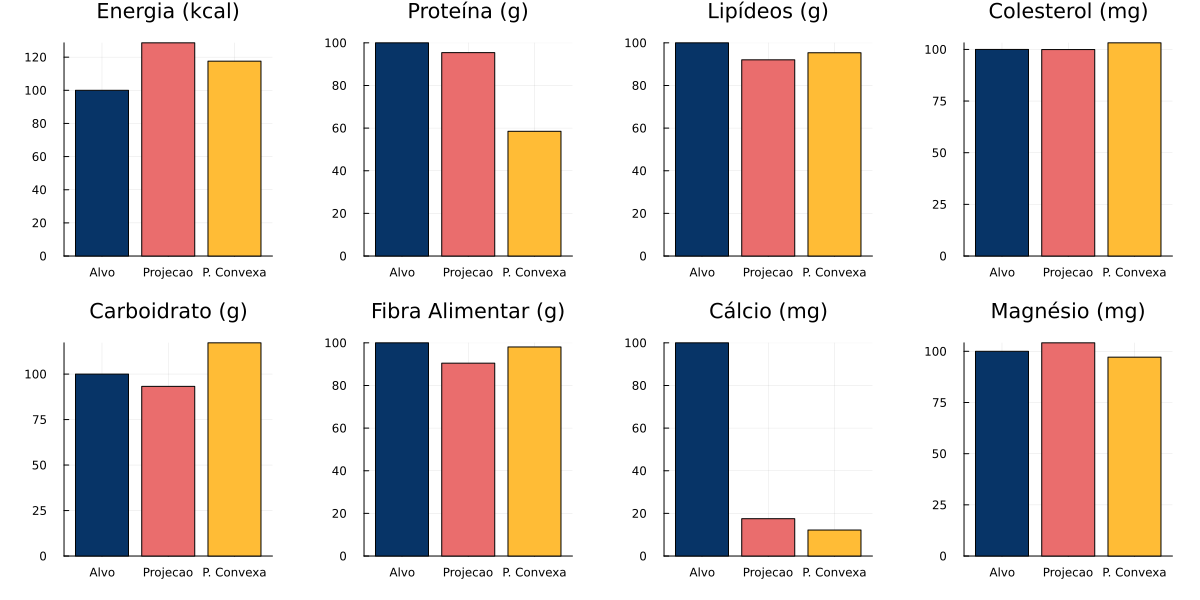

In [123]:
categorias = ["Alvo", "Projecao", "P. Convexa"]
nutrientes = names(df)
nutrientes = nutrientes[2: length(nutrientes)]

A = vetor_alvo  # Valores do vetor A
B = vetorProjecao  # Valores do vetor B
C = vetor_convexo  # Valores do vetor C

# Criando os gráficos individuais com cores diferentes para cada vetor
bar_plots = []
for i in 1:8
    # Plotando cada gráfico com cores específicas para A, B e C
    push!(bar_plots, bar(categorias, [A[i], B[i], C[i]], label=false, color=["#073467", "#ea6d6d", "#ffbc36"], title=nutrientes[i]))
end

# Organizando os gráficos lado a lado
plot(bar_plots..., layout=(2, 4), size=(1200, 600), top_margin=5mm, left_margin=5mm, right_margin=5mm, bottom_margin=5mm)